In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

import torch
from torch.utils.data import TensorDataset, DataLoader
from src.model_specpred_continuous import ContinuousSpectrumPredictor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("data/CrI3/20221110_continuous.pt")
X = data['param'][:,:2]
Y = data['inten'].to(X)
omega = data['omega']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1/5, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [3]:
feat_hid_list = [4, 32, 256, 512, 1024]
model_spec = ContinuousSpectrumPredictor(X.shape[1], Y.shape[1], feat_hid_list)
print(model_spec)

ContinuousSpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=101, bias=False)
    (11): ReLU()
  )
)


In [4]:
trainer = pl.Trainer(
    max_epochs=10000, accelerator="gpu",
    callbacks=[TQDMProgressBar(refresh_rate=5)],
    log_every_n_steps=2, devices=1, 
    enable_checkpointing=True,
    default_root_dir="training_logs"
    )

trainer.fit(model_spec, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | fc_net | Sequential | 768 K 
--------------------------------------
768 K     Trainable params
0         Non-trainable params
768 K     Total params
3.076     Total estimated model params size (MB)
c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 561:  80%|████████  | 20/25 [00:00<00:00, 138.30it/s, loss=0.0495, v_num=46]

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
model_spec.eval()
with torch.no_grad():
    y_val_pred = model_spec(X_val.to(model_spec.device))

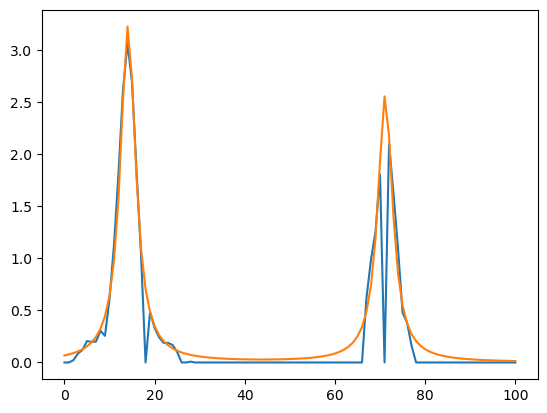

In [7]:
idx = 9
plt.plot(y_val_pred[idx].cpu())
plt.plot(Y_val[idx].cpu())

In [8]:

from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt
time_val = torch.linspace(0,10,1001)
# pred_S = model_function((time_val,), true_pars, ())
pred_S = batch_spec_to_Sqt(omega, y_val_pred[idx].cpu(), time_val).sum(dim=1).squeeze()
true_S = batch_spec_to_Sqt(omega, Y_val[idx].cpu(), time_val).sum(dim=1).squeeze()

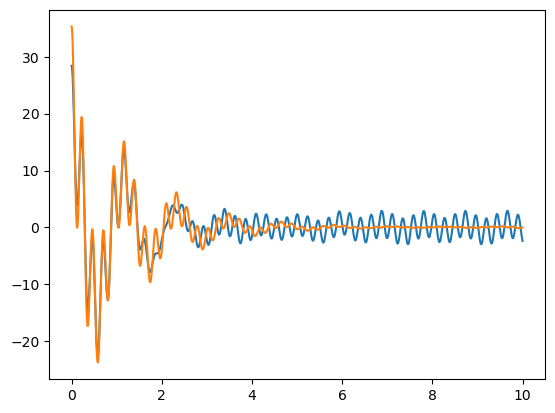

In [9]:
plt.plot(time_val, pred_S)
plt.plot(time_val, true_S)

In [6]:
model_spec.load_from_checkpoint("training_logs/lightning_logs/version_0/checkpoints/epoch=9999-step=210000.ckpt")

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=False)
  )
)

In [10]:
Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val).detach())
Y_val_pred = torch.vstack(Y_val_pred)

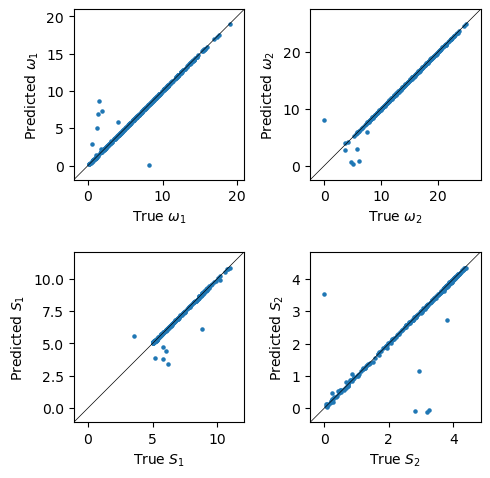

In [43]:
labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()

In [38]:
x_val = X_val[0]
y_val_pred = model_spec(x_val)

In [39]:
y_val_pred

tensor([ 6.1968, 16.1807,  5.2981,  3.7198], grad_fn=<SqueezeBackward3>)